## Import Section

In [39]:
#Deniz N. Cakan
from natsort import natsorted
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colorbar
import seaborn as sns
import warnings
from tqdm import tqdm
from matplotlib import style
import numpy as np
import h5py as h5
import h5py
import matplotlib.pyplot as plt
import os
from apstools import s2, xrf
import frgtools.plotting as frgplt
import frgtools.misc as frgm 
import mendeleev as men
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # can remove this if youre not on a mbp
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.rcParams['axes.linewidth'] = 1.75 #set the value globally
import matplotlib.colors as colors
import xraydb
from matplotlib import patches
from matplotlib.patches import Rectangle
def notick(ax):
    for ax_ in ax:
        ax_.set_yticklabels([])
        ax_.set_xticklabels([])  
        ax_.tick_params(left=False, bottom= False)

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [40]:
root = '/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_202112_2IDD/demo'

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
fids = []
for f in frgm.listdir(root + '/img.dat', display=False):
    if 'control' in f and '_rgb' not in f:
        continue
    fids.append(f)
# print('should be 21 for inorganic 16 for hybrid, 6-roi, 10-xbic-wf, 5-xrf-wf')

print('total: '+str(len(fids)))
fids = natsorted(fids)


total: 14


In [42]:
for number, letter in enumerate(fids):
    print(letter, number)

/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_202112_2IDD/demo/img.dat/2idd_0048.h5 0
/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_202112_2IDD/demo/img.dat/2idd_0059.h5 1
/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_202112_2IDD/demo/img.dat/2idd_0060.h5 2
/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_202112_2IDD/demo/img.dat/2idd_0062.h5 3
/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_202112_2IDD/demo/img.dat/2idd_0063.h5 4
/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_202112_2IDD/demo/img.dat/2idd_0065.h5 5
/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_202112_2IDD/demo/img.dat/2idd_0066.h5 6
/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_202112_2IDD/demo/img.dat/2idd_0068.h5 7
/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_202112_2IDD/demo/img.dat/2idd_0069.h5 8
/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_

## Sample List

In [43]:
# import your scan list into here, define scan parameters here
sample_key = {

    48: dict(
        sample="TPV_6",
        beam_energy=16.4,
        xbic_scaler = 1,
        channels=["Si", "Cs_L", "Pb_L", "I_L", "Br", 'Zn', 'In_L'],
    ), 

    59: dict(
        sample="TPV_7",
        beam_energy=16.4,
        xbic_scaler = 1,
        channels=["Si", "Cs_L", "Pb_L", "I_L", "Br", 'Zn', 'In_L'],

    ),
    
    62: dict(
        sample="TPV_8",
        beam_energy=16.4,
        xbic_scaler = 1,
        channels=["Si", "Cs_L", "Pb_L", "I_L", "Br", 'Zn', 'In_L'],

    ),
    
    65: dict(
        sample="TPV_9",
        beam_energy=16.4,
        xbic_scaler = 1,
        channels=["Si", "Cs_L", "Pb_L", "I_L", "Br", 'Zn', 'In_L'],

    ),
    
    68: dict(
        sample="TPV_3",
        beam_energy=16.4,
        xbic_scaler = 1,
        channels=["Si", "Cs_L", "Pb_L", "I_L", "Br", 'Zn', 'In_L'],

    ),
    
    223: dict(
        sample="Hybrid-XEOL",
        beam_energy=16.4,
        xbic_scaler = 1,
        channels=["Si", "Cs_L", "Pb_L", "I_L", "Br", 'Zn', 'In_L'],

    ),
    
    224: dict(
        sample="Hybrid-XRF",
        beam_energy=16.4,
        xbic_scaler = 1,
        channels=["Si", "Cs_L", "Pb_L", "I_L", "Br", 'Zn', 'In_L'],

    ),

}


## Function to generate filepath from scan number

In [44]:
def findscan(scannum):
    fids = os.listdir(os.path.join(root, 'img.dat'))
    for x in fids:
        if '2idd_' in x:
            if int(x.split('2idd_')[1][:-3]) == scannum:
                return os.path.join(root, 'img.dat', x)
    return False

def _load_scan_info(scannum):
    out = {}
    with h5py.File(findscan(scannum), 'r') as d:
        livetime_index = np.where(d['MAPS']['scaler_names'][()] == b'ELT1')[0][0]
        out['dwell'] = np.round(d['MAPS']['scalers'][livetime_index].mean()*1, 3)
        out['x0'] = d['MAPS']['x_axis'][()].mean()
        out['y0'] = d['MAPS']['y_axis'][()].mean()
        out['xrange'] = np.ptp(d['MAPS']['x_axis'][()])
        out['yrange'] = np.ptp(d['MAPS']['y_axis'][()])
        out['dx'] = np.round(np.abs(np.diff(d['MAPS']['x_axis'][()])[0]), 3)
        out['dy'] = np.round(np.abs(np.diff(d['MAPS']['y_axis'][()])[0]), 3)
    
    sample_info = _lookup_sample_info(scannum)
    out['sample'] = sample_info['sample']
    out['beam_energy'] = sample_info['beam_energy']
    out['xbic_scaler'] = sample_info['xbic_scaler']
    return out

def _lookup_sample_info(scannum):
    starting_scans = np.asarray(list(sample_key.keys()))
    starting_scans.sort()
    idx = np.where(scannum >= starting_scans)[0].max()
    key = starting_scans[idx]
    
    return sample_key[key]

## Attenuation coefficient

### Double-check lines

In [58]:
for name, line in xraydb.xray_lines('In').items():
    print(name, ' = ', line)

Ka3  =  XrayLine(energy=23702.0, intensity=0.000484013, initial_level='K', final_level='L1')
Ka2  =  XrayLine(energy=24002.0, intensity=0.287792, initial_level='K', final_level='L2')
Ka1  =  XrayLine(energy=24210.0, intensity=0.539772, initial_level='K', final_level='L3')
Kb3  =  XrayLine(energy=27236.8, intensity=0.0482742, initial_level='K', final_level='M2')
Kb1  =  XrayLine(energy=27274.7, intensity=0.0929325, initial_level='K', final_level='M3')
Kb5  =  XrayLine(energy=27488.6, intensity=0.00124838, initial_level='K', final_level='M4,5')
Kb2  =  XrayLine(energy=27866.5, intensity=0.0291477, initial_level='K', final_level='N2,3')
Kb4  =  XrayLine(energy=27922.3, intensity=0.000349124, initial_level='K', final_level='N4,5')
Lb4  =  XrayLine(energy=3534.8, intensity=0.312033, initial_level='L1', final_level='M2')
Lb3  =  XrayLine(energy=3572.7, intensity=0.496793, initial_level='L1', final_level='M3')
Lg2  =  XrayLine(energy=4164.5, intensity=0.0842065, initial_level='L1', final_leve

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Continue

In [45]:
Cs_L_emission_line=4.2865
Pb_M_emission_line=2.3455
Pb_L_emission_line=10.5515
I_L_emission_line =3.93765
Br_L_emission_line=1.48043
Br_emission_line=11.9242
Cl_emission_line=2.62239
Zn_emission_line = 8.637
In_L_emission_line = 3.286
Au_M_emission_line=2.1184
Au_L_emission_line=9.71


data = {
    #meta data
    'scannum': [],
    'sample': np.array,
    'beam_energy': np.array,
    'xbic_scaler':np.array,
    'dwell': np.array,
    'x0': np.array,
    'y0': np.array,
    'xrange': np.array,
    'yrange': np.array,
    'dx': np.array,
    'dy': np.array,
    
    #scan data|
    'xbic': np.array,
    'x':np.array,
    'y':np.array,
    'spectra':np.array,
    'intspectra':np.array,
    'extent':np.array,
    'fitted':np.array,
    'energy': np.array,
    'ds_ic': np.array,
    'Si': np.array,
    'Au_M' : np.array, 
    'Au_L' : np.array,
    'Cs_L': np.array, 
    'Pb_L': np.array,
    'Pb_M': np.array,    
    'I_L': np.array, 
    'Br_L': np.array,
    'Br': np.array,
    'Cl': np.array,

    'Zn': np.array,
    'In_L': np.array,

    'Zn_mol': np.array,
    'In_L_mol': np.array,

    'Au_M_mol': np.array,
    'Au_L_mol': np.array,
    'Cs_L_mol': np.array,
    'Pb_L_mol': np.array,
    'Pb_M_mol': np.array,
    'I_L_mol' : np.array,
    'Br_mol': np.array,
    'Cl_mol': np.array,

}

for f in fids:
    data['scannum'].append(int(os.path.basename(f)[6:-3]))
df = pd.DataFrame(data)

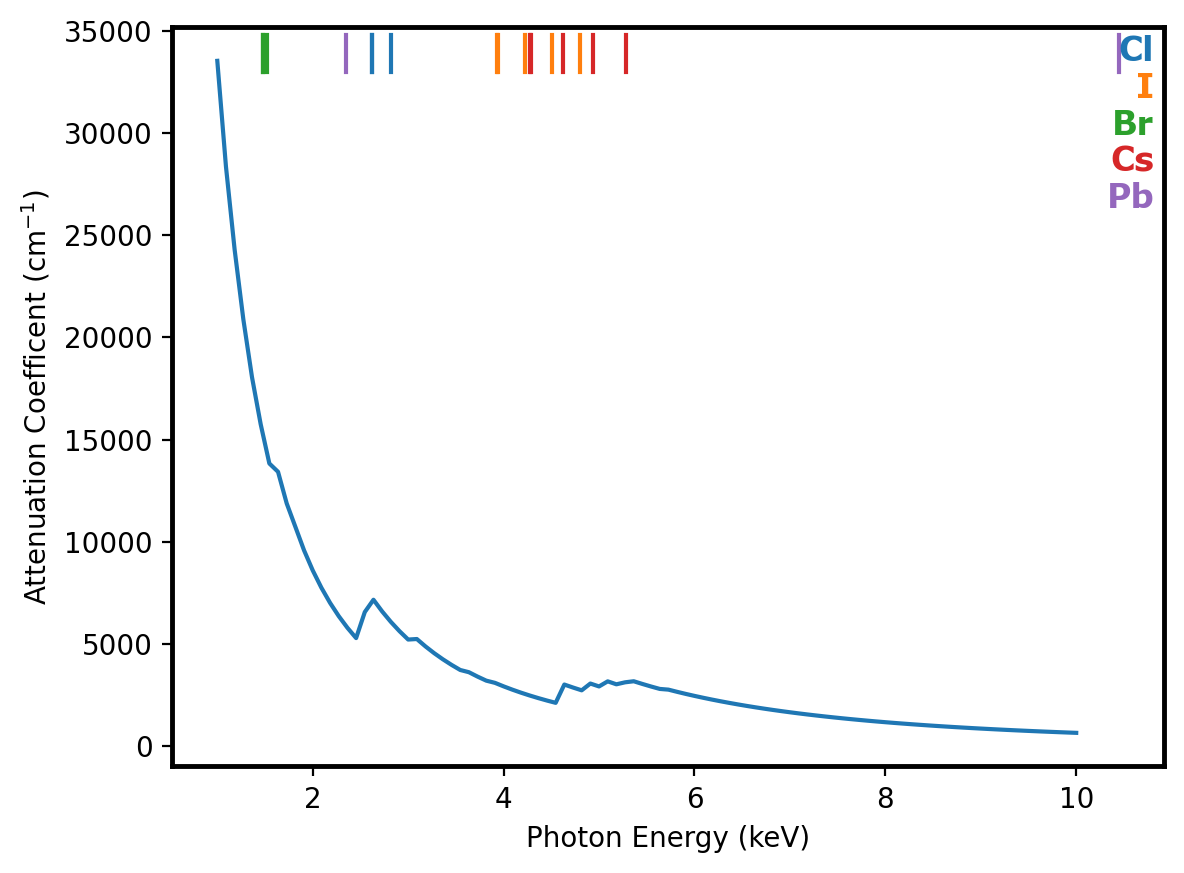

In [46]:
elements = {
    'Cs': 1,
    'Pb': 1,
    'Br': 0.6,
    'I': 2.4
} #formula units for each element

density = 4.4 #best estimate of density, g/cm3

film_material = xrf.Material(
    elements = elements,
    density = density
)

energy = np.linspace(1,10,100) #keV
att = film_material.attenuation_coefficient(energy)

plt.plot(energy, att)
plt.xlabel('Photon Energy (keV)')
plt.ylabel('Attenuation Coefficent (cm$^{-1}$)')

xrf.plot_XRF_lines(
    ['Cl', 'I', 'Br', 'Cs', 'Pb'],
    tickloc = 'top',
    tickstagger = 0 #usually only need 0.01-0.05 here if lines are really overlapping
)
plt.show()

## Self-absorption

In [47]:
energy_low = 7
energy_high = 16.4

        
        
Au_M_intensity_after_self_abs = xrf.self_absorption_film(
    material = film_material, #material we defined earlies
    thickness = 70e-7, #500 nm, but given in cm!
    incidentenergy = energy_low, #beam energy, in keV
    xrfenergy = Au_M_emission_line, #energy of fluorescence in question
    sampletheta = 105, #angle, degrees, between incident beam and sample normal. remember your unit circle direction! 2IDD this angle is (i think) 15 degrees off normal
    detectortheta = 270, #angle, degrees, between incident beam and detector axis. 
)

Au_L_intensity_after_self_abs = xrf.self_absorption_film(
    material = film_material, #material we defined earlies
    thickness = 70e-7, #500 nm, but given in cm!
    incidentenergy = energy_high, #beam energy, in keV
    xrfenergy = Au_L_emission_line, #energy of fluorescence in question
    sampletheta = 105, #angle, degrees, between incident beam and sample normal. remember your unit circle direction! 2IDD this angle is (i think) 15 degrees off normal
    detectortheta = 270, #angle, degrees, between incident beam and detector axis. 
)
        
        
Cs_L_intensity_after_self_abs = xrf.self_absorption_film(
    material = film_material, #material we defined earlies
    thickness = 500e-7, #500 nm, but given in cm!
    incidentenergy = energy_low, #beam energy, in keV
    xrfenergy = Cs_L_emission_line, #energy of fluorescence in question
    sampletheta = 105, #angle, degrees, between incident beam and sample normal. remember your unit circle direction! 2IDD this angle is (i think) 15 degrees off normal
    detectortheta = 270, #angle, degrees, between incident beam and detector axis. 
)


Pb_M_intensity_after_self_abs = xrf.self_absorption_film(
    material = film_material, #material we defined earlies
    thickness = 500e-7, #500 nm, but given in cm!
    incidentenergy = energy_high, #beam energy, in keV
    xrfenergy = Pb_M_emission_line, #energy of fluorescence in question
    sampletheta = 105, #angle, degrees, between incident beam and sample normal. remember your unit circle direction! 2IDD this angle is (i think) 15 degrees off normal
    detectortheta = 270, #angle, degrees, between incident beam and detector axis. 
)

Pb_L_intensity_after_self_abs = xrf.self_absorption_film(
    material = film_material, #material we defined earlies
    thickness = 500e-7, #500 nm, but given in cm!
    incidentenergy = energy_high, #beam energy, in keV
    xrfenergy = Pb_L_emission_line, #energy of fluorescence in question
    sampletheta = 105, #angle, degrees, between incident beam and sample normal. remember your unit circle direction! 2IDD this angle is (i think) 15 degrees off normal
    detectortheta = 270, #angle, degrees, between incident beam and detector axis. 
)
I_L_intensity_after_self_abs = xrf.self_absorption_film(
    material = film_material, #material we defined earlies
    thickness = 500e-7, #500 nm, but given in cm!
    incidentenergy = energy_low, #beam energy, in keV
    xrfenergy = I_L_emission_line, #energy of fluorescence in question
    sampletheta = 105, #angle, degrees, between incident beam and sample normal. remember your unit circle direction! 2IDD this angle is (i think) 15 degrees off normal
    detectortheta = 270, #angle, degrees, between incident beam and detector axis. 
)

Br_intensity_after_self_abs = xrf.self_absorption_film(
    material = film_material, #material we defined earlies
    thickness = 500e-7, #500 nm, but given in cm!
    incidentenergy = energy_high, #beam energy, in keV
    xrfenergy = Br_emission_line, #energy of fluorescence in question
    sampletheta = 105, #angle, degrees, between incident beam and sample normal. remember your unit circle direction! 2IDD this angle is (i think) 15 degrees off normal
    detectortheta = 270, #angle, degrees, between incident beam and detector axis. 
)


Br_L_intensity_after_self_abs = xrf.self_absorption_film(
    material = film_material, #material we defined earlies
    thickness = 500e-7, #500 nm, but given in cm!
    incidentenergy = energy_high, #beam energy, in keV
    xrfenergy = Br_emission_line, #energy of fluorescence in question
    sampletheta = 105, #angle, degrees, between incident beam and sample normal. remember your unit circle direction! 2IDD this angle is (i think) 15 degrees off normal
    detectortheta = 270, #angle, degrees, between incident beam and detector axis. 
)

Cl_intensity_after_self_abs = xrf.self_absorption_film(
    material = film_material, 
    thickness = 500e-7, 
    incidentenergy = energy_low, 
    xrfenergy = Cl_emission_line, 
    sampletheta = 105, 
    detectortheta = 270, 
)

Zn_intensity_after_self_abs = xrf.self_absorption_film(
    material = film_material, 
    thickness = 250e-7, 
    incidentenergy = energy_low, 
    xrfenergy = Zn_emission_line, 
    sampletheta = 105, 
    detectortheta = 270, 
)

In_L_intensity_after_self_abs = xrf.self_absorption_film(
    material = film_material, 
    thickness = 250e-7, 
    incidentenergy = energy_low, 
    xrfenergy = In_L_emission_line, 
    sampletheta = 105, 
    detectortheta = 270, 
)

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Generating Dataframe

In [48]:
warnings.filterwarnings('ignore')
for n in tqdm(range(0 , len(df))):
    #meta data
    meta_data_1 = _load_scan_info(df['scannum'][n])
    df['dwell'][n] = meta_data_1['dwell']
    df['x0'][n] = meta_data_1['x0']
    df['y0'][n] = meta_data_1['y0']
    df['xrange'][n] = meta_data_1['xrange']
    df['yrange'][n] = meta_data_1['yrange']
    df['dx'][n] = meta_data_1['dx']
    df['dy'][n] = meta_data_1['dy']
    
    meta_data_2 = _lookup_sample_info(df['scannum'][n])
    df['sample'][n] = meta_data_2['sample']
    df['beam_energy'][n] = meta_data_2['beam_energy']
    df['xbic_scaler'][n] = meta_data_2['xbic_scaler']

    
    #scan data
    scan_data = s2.load_h5(findscan(df['scannum'][n]), xbic_on_dsic=True)
    df['x'][n] = scan_data['x']
    df['y'][n] = scan_data['y']
    df['spectra'][n] = scan_data['spectra']
    df['energy'][n] = scan_data['energy']
    df['intspectra'][n] = scan_data['intspectra']
    df['extent'][n] = scan_data['extent']
    df['fitted'][n] = scan_data['fitted']
    #maps
    maps = scan_data['maps']
    
    #low energy lines
    if df['beam_energy'][n] == 7:

        if 'xbic' in maps:
            df['xbic'][n] = maps['xbic']

# just ebic            
            
        if 'Cl' in maps:
            df['Cl'][n] = maps['Cl']   
            df['Cl_mol'][n] =  df['Cl'][n]/Cl_intensity_after_self_abs/men.Cl.mass/1e3

        if 'I_L' in maps:
            df['I_L'][n] = maps['I_L']    
            df['I_L_mol' ][n] =  df['I_L'][n]/I_L_intensity_after_self_abs/ men.I.mass/1e3

        if 'Cs_L' in maps:
            df['Cs_L'][n] = maps['Cs_L']
            df['Cs_L_mol'][n] =  df['Cs_L'][n]/Cs_L_intensity_after_self_abs/men.Cs.mass/1e3

        if 'Pb_M' in maps:
            df['Pb_M'][n] = maps['Pb_M']
            df['Pb_M_mol'][n] =  df['Pb_M'][n]/Pb_M_intensity_after_self_abs/men.Pb.mass/1e3
            
        if 'Au_M' in maps:
            df['Au_M'][n] = maps['Au_M']
            df['Au_M_mol'][n] =  df['Au_M'][n]/Au_M_intensity_after_self_abs/men.Au.mass/1e3

    #high energy lines
    if df['beam_energy'][n] == 16.4:
        try:
            if 'Br' in maps:
                df['Br'][n] = maps['Br']    
                df['Br_mol'][n] =  np.roll(df['Br'][n]/ Br_intensity_after_self_abs/ men.Br.mass/1e3, 6, axis = 1)

            if 'Pb_L' in maps:
                df['Pb_L'][n] = maps['Pb_L']
                df['Pb_L_mol'][n] =  np.roll(df['Pb_L'][n]/Pb_L_intensity_after_self_abs/men.Pb.mass/1e3, 6, axis = 1)
                
            if 'Cs_L' in maps:
                df['Cs_L'][n] = maps['Cs_L']
                df['Cs_L_mol'][n] =  df['Cs_L'][n]/Cs_L_intensity_after_self_abs/men.Cs.mass/1e3
                
            if 'Zn' in maps:
                df['Zn'][n] = maps['Zn']
                df['Zn_mol'][n] =  np.roll(df['Zn'][n]/Au_L_intensity_after_self_abs/men.Zn.mass/1e3, 6, axis = 1)

            if 'In_L' in maps:
                df['In_L'][n] = maps['In_L']
                df['In_L_mol'][n] =  np.roll(df['In_L'][n]/In_L_intensity_after_self_abs/men.In.mass/1e3, 6, axis = 1)

            if 'I_L' in maps:
                df['I_L'][n] = maps['I_L']    
                df['I_L_mol' ][n] =  df['I_L'][n]/I_L_intensity_after_self_abs/ men.I.mass/1e3
                
                
        except:
            continue

        
# extra fun ratios and additional analysis to run:
# I_x_fraction = I_mol / (Br_mol+Cl_mol + I_mol) #we assume barium incorporates on the b-site, this will give the b-site fraction of Ba
# Br_x_fraction = Br_mol / (Br_mol+Cl_mol + I_mol) #we assume barium incorporates on the b-site, this will give the b-site fraction of Ba
# Cl_x_fraction = Cl_mol / (Br_mol+Cl_mol + I_mol) #we assume barium incorporates on the b-site, this will give the b-site fraction of Ba

warnings.filterwarnings('default')

100%|██████████| 14/14 [00:16<00:00,  1.16s/it]


In [49]:
df.columns # this is to check that you have all the data you need to start running analysis

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Index(['scannum', 'sample', 'beam_energy', 'xbic_scaler', 'dwell', 'x0', 'y0',
       'xrange', 'yrange', 'dx', 'dy', 'xbic', 'x', 'y', 'spectra',
       'intspectra', 'extent', 'fitted', 'energy', 'ds_ic', 'Si', 'Au_M',
       'Au_L', 'Cs_L', 'Pb_L', 'Pb_M', 'I_L', 'Br_L', 'Br', 'Cl', 'Zn', 'In_L',
       'Zn_mol', 'In_L_mol', 'Au_M_mol', 'Au_L_mol', 'Cs_L_mol', 'Pb_L_mol',
       'Pb_M_mol', 'I_L_mol', 'Br_mol', 'Cl_mol'],
      dtype='object')

## Filtering to Desired Scans

In [50]:
# this is to filter out to specific scans that you are interested in 
Filter_1 = 'TPV'
Filter_2 = ''
Filter_3 = ''

df_filter1 = df[df['sample'].str.contains(Filter_1)]
df_filter2 = df_filter1[df_filter1['sample'].str.contains(Filter_2)]
df_filter3 = df_filter2[df_filter2['sample'].str.contains(Filter_3)]
df_filter3.reset_index(drop=True, inplace=True)

# list scans in your filtered dataset before plotting
for n in df_filter3['sample'].unique(): print(n)
    
print(f'there are a total of {df_filter3.shape[0]} scans')

TPV_6
TPV_7
TPV_8
TPV_9
TPV_3
there are a total of 9 scans


## Compensating for thickness

In [51]:
dfp = df_filter3
dfp['total_xrf'] = ''
for n in range(dfp.shape[0]): 
    dfp['total_xrf'][n] = (dfp['Cs_L_mol'][n] + dfp['Pb_L_mol'][n] + dfp['I_L_mol'][n]  +  dfp['Br_mol'][n] + dfp['Zn_mol'][n]+ dfp['In_L_mol'][n])

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


## Tweaking Plotting Parameters

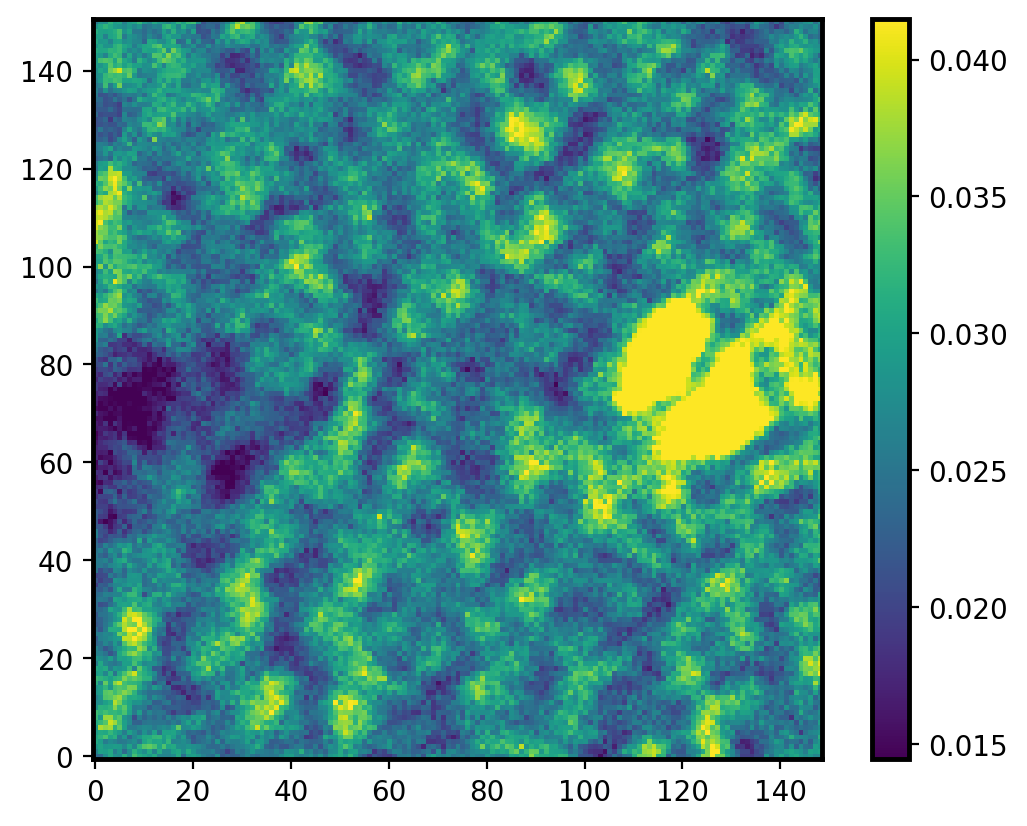

In [52]:
# sandbox for tweaking plotting conditions, plots a single element from a single scan 
cm1 = mpl.cm.get_cmap("coolwarm")
cm2 = mpl.cm.get_cmap("viridis")


CsL_dfp = dfp['Cs_L_mol'][0]/dfp['total_xrf'][0] #what we want to plot is long so saving it as a variable, element_counts/total_counts
CsL_dfp[CsL_dfp==0]=np.nan  # this step is if you had masked pinholes prior 

# CsL_dfp = CsL_dfp/np.nanmean(CsL_dfp)
im = plt.imshow(CsL_dfp, cmap = cm2, origin='lower',
    vmin = (np.nanmean(CsL_dfp)-2*np.nanstd(CsL_dfp)),
    vmax = (np.nanmean(CsL_dfp)+2*np.nanstd(CsL_dfp))
               )



plt.colorbar()
plt.show()

## Plotting The Mega-Plot

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
  if __name__ == '__main__':
/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  # Remove the CWD from sys.path while we load stuff.


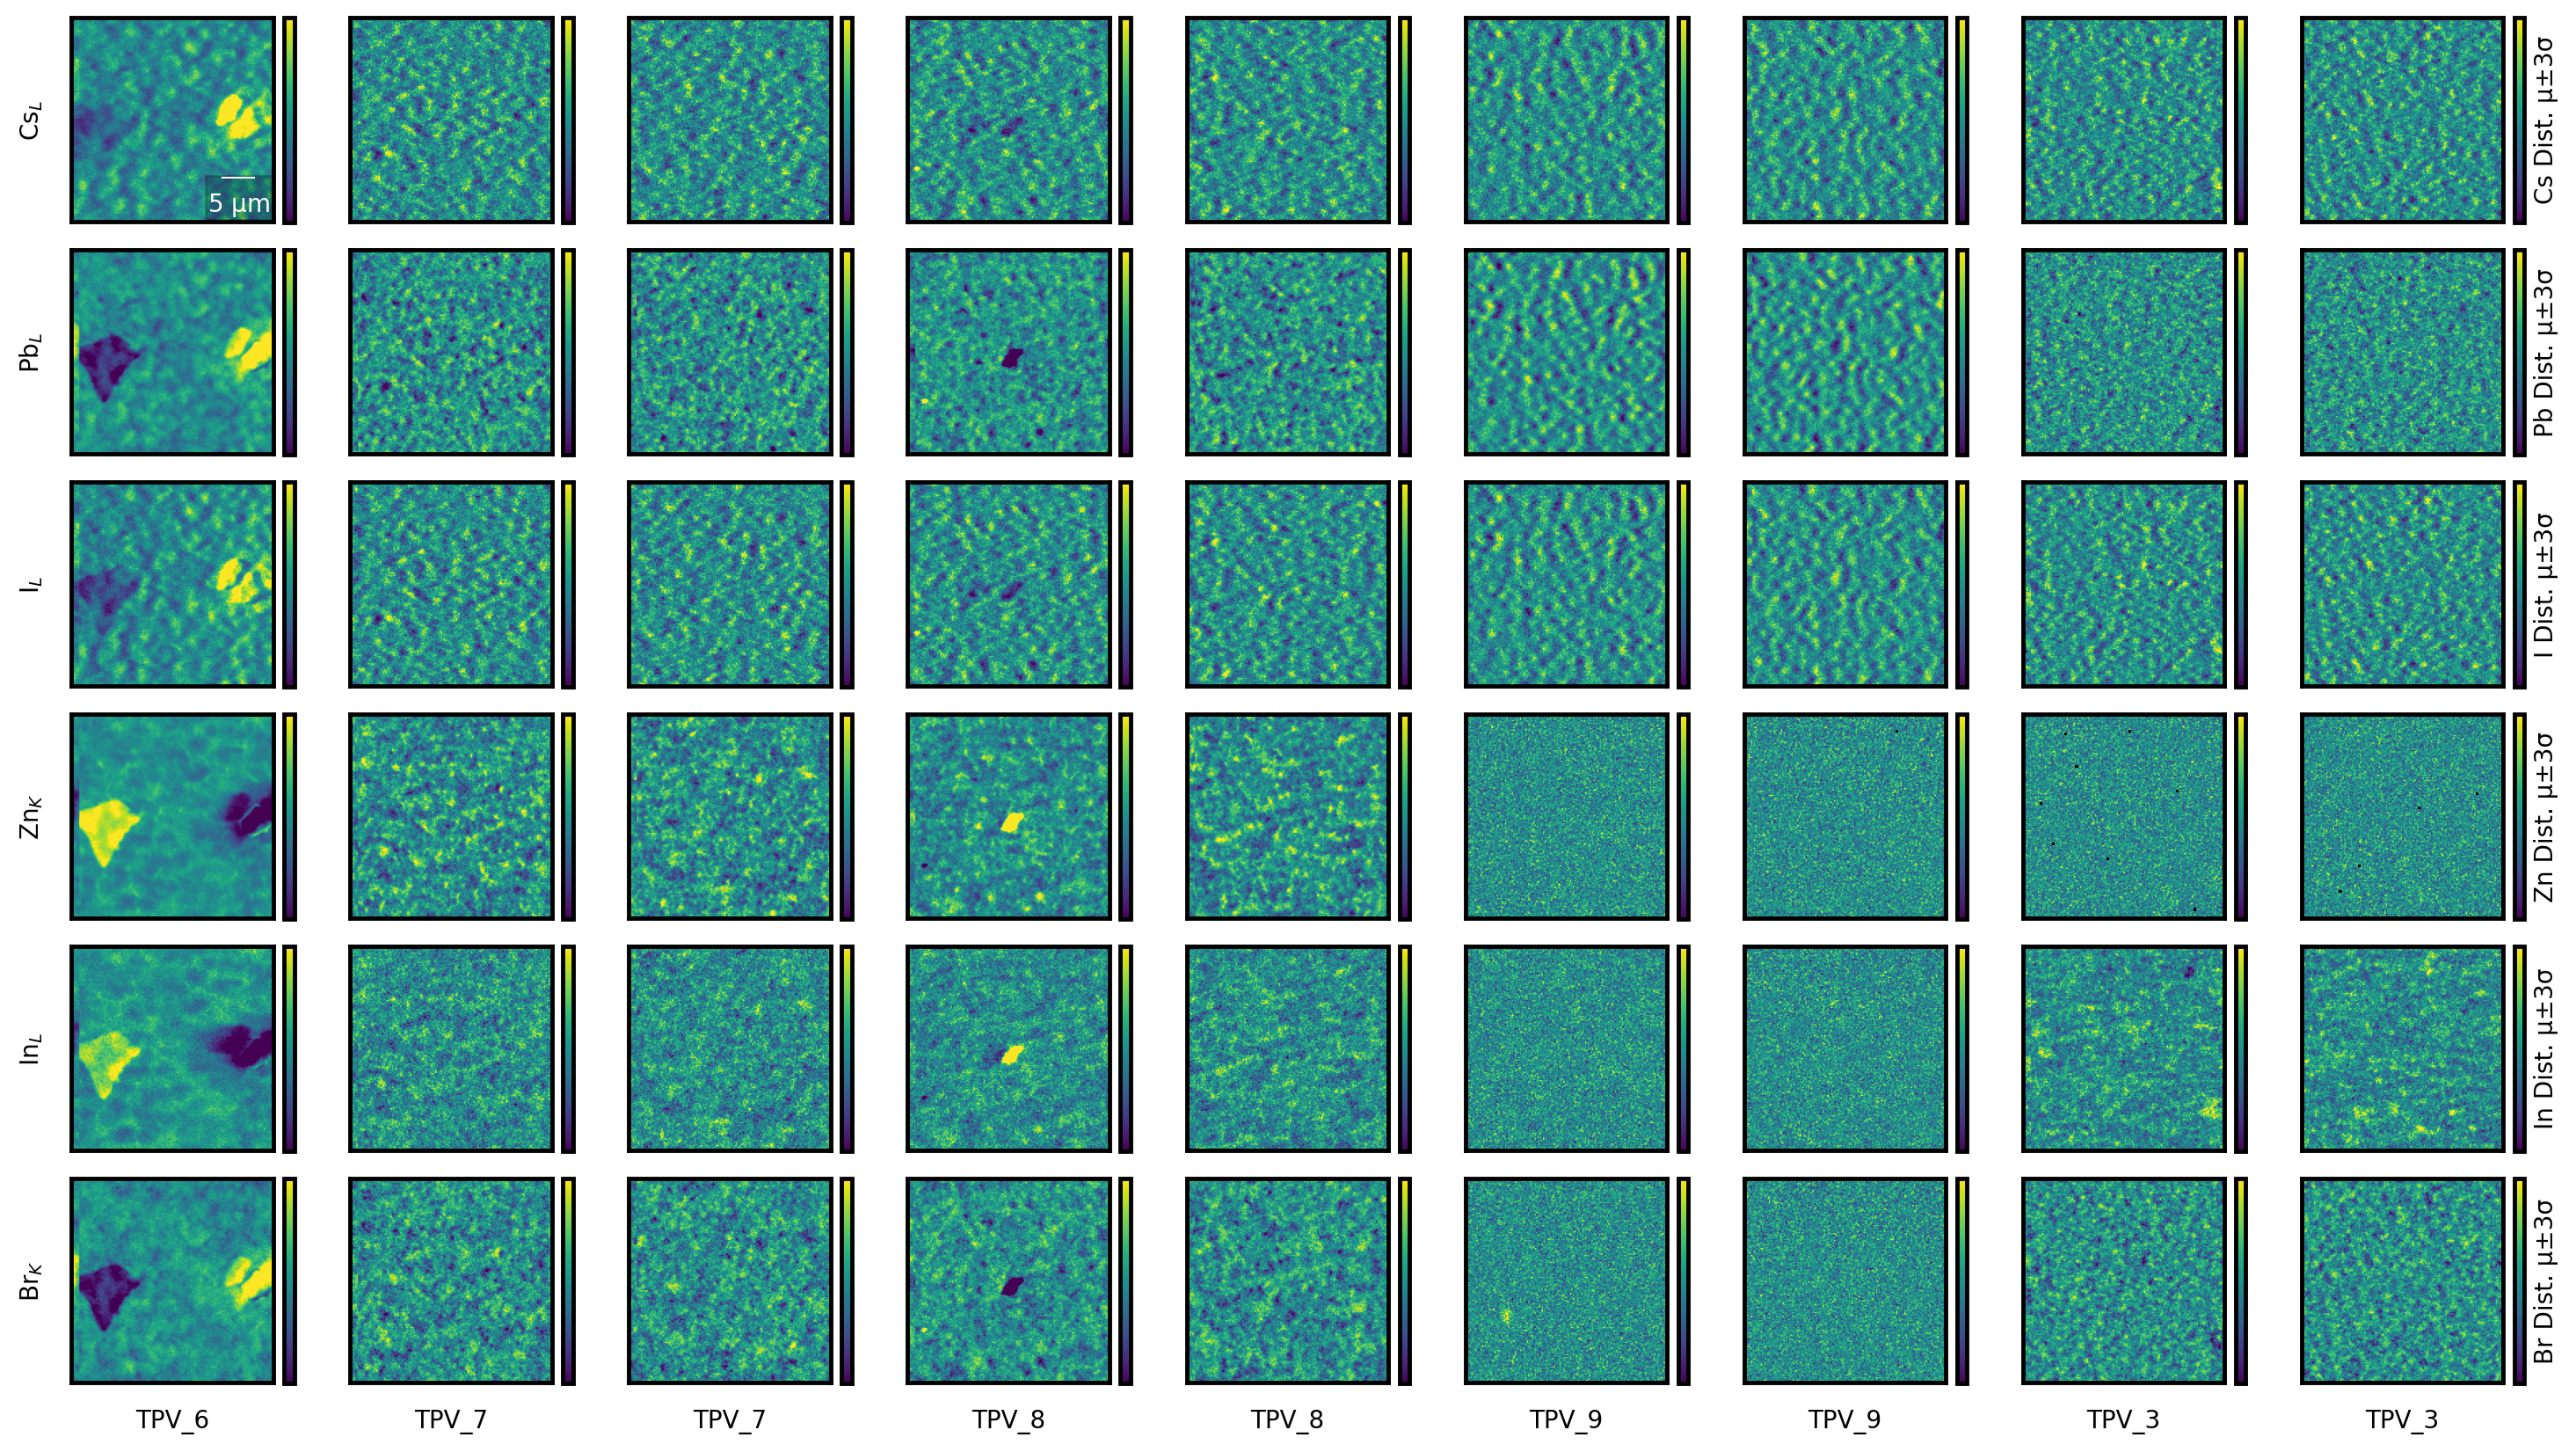

In [53]:
# dfp = dfp # data for plotting
embiggen = 2
horiz = dfp.shape[0]
vert = 6 # 7 channels + 1 ratio
fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen, vert*embiggen))
objs = ['literallyanything' for i in range(vert*horiz)]
cm1 = mpl.cm.get_cmap("coolwarm") # divering color
cm2 = mpl.cm.get_cmap("viridis") # linear color
cm1.set_bad(color='black') # this is if a mask was set, it will now turn the pinhole black
cm2.set_bad(color='black') # this is if a mask was set, it will now turn the pinhole black

cmap_choice = cm2

std_range = 3
setlim = True #choosing which mapping channel to go with, to have ability to plot the same thing with 2 differnt options

for n, ax_ in zip(range(0, dfp.shape[0]), ax.ravel()):
    if setlim == True:
        CsL_dfp = dfp['Cs_L_mol'][n]/dfp['total_xrf'][n] # *mask_array_low[n] if masking, what we want to plot is long so saving it as a variable, element_counts/total_counts, 
        CsL_dfp[CsL_dfp==0]=np.nan  # this step is if you had masked pinholes prior         
        im = ax_.imshow(CsL_dfp, origin='lower', vmin = (np.nanmean(CsL_dfp)-std_range*np.nanstd(CsL_dfp)), vmax = (np.nanmean(CsL_dfp)+std_range*np.nanstd(CsL_dfp)),cmap = cmap_choice)

    if setlim == False:
        CsL_dfp = dfp['Cs_L_mol'][n]/dfp['total_xrf'][n] 
        CsL_dfp[CsL_dfp==0]=np.nan      
        im = ax_.imshow(CsL_dfp, origin='lower', cmap = cmap_choice)
        
    if n == 0: 
        ax_.set_ylabel('Cs$_L$')       
    if n >(horiz-2):
        objs[n+horiz*0]= plt.colorbar(im, ax = ax[0,n], label = f'Cs Dist. µ±{std_range}σ', fraction = 0.046)

    if n <(horiz-1):
        objs[n+horiz*0] = plt.colorbar(im, ax = ax[0,n], fraction = 0.046)
    ax_.tick_params(left=False, bottom= False)
    ax_.set_yticklabels([])
    ax_.set_xticklabels([])
#     ax_.set_yticks(rotation=90)
#     ax_.set_title('Cs_M')
#     ax_.set_xlabel(dfp['sample'][n])
    
for n, ax_ in zip(range(0, dfp.shape[0]), ax[1].ravel()):
    if setlim == True:
        
        PbL_dfp = dfp['Pb_L_mol'][n]/dfp['total_xrf'][n]
        PbL_dfp[PbL_dfp==0]=np.nan
        im = ax_.imshow(PbL_dfp, origin='lower', vmin = (np.nanmean(PbL_dfp)-std_range*np.nanstd(PbL_dfp)), vmax = ((np.nanmean(PbL_dfp)+std_range*np.nanstd(PbL_dfp))),cmap = cmap_choice)
        
    if setlim == False:
        PbL_dfp = dfp['Pb_L_mol'][n]/dfp['total_xrf'][n]
        PbL_dfp[PbL_dfp==0]=np.nan
        im = ax_.imshow(PbL_dfp, origin='lower',cmap = cmap_choice)
        
    if n == 0: 
        ax_.set_ylabel('Pb$_L$')
    if n >(horiz-2):
        objs[n+horiz*1]= plt.colorbar(im, ax = ax[1,n], label = f'Pb Dist. µ±{std_range}σ', fraction = 0.046)
    if n <(horiz-1):
        objs[n+horiz*1]= plt.colorbar(im, ax = ax[1,n], fraction = 0.046)

    ax_.tick_params(left=False, bottom= False)

    ax_.set_yticklabels([])
    ax_.set_xticklabels([])    
    
    
for n, ax_ in zip(range(0, dfp.shape[0]), ax[2].ravel()):
    if setlim == True:
        IL_dfp = dfp['I_L_mol'][n]/dfp['total_xrf'][n]
        IL_dfp[IL_dfp==0]=np.nan
        im = ax_.imshow(IL_dfp, origin='lower', vmin = (np.nanmean(IL_dfp)-std_range*np.nanstd(IL_dfp)), vmax = (np.nanmean(IL_dfp)+std_range*np.nanstd(IL_dfp)),cmap = cmap_choice)
    
    if setlim == False:
        IL_dfp = dfp['I_L_mol'][n]/dfp['total_xrf'][n]
        IL_dfp[IL_dfp==0]=np.nan
        im = ax_.imshow(IL_dfp, origin='lower', cmap = cmap_choice)

    if n == 0: 
        ax_.set_ylabel('I$_L$')       
    if n >(horiz-2):
        objs[n+horiz*2]= plt.colorbar(im, ax = ax[2,n], label = f'I Dist. µ±{std_range}σ', fraction = 0.046)
    if n <(horiz-1):
        objs[n+horiz*2]= plt.colorbar(im, ax = ax[2,n], fraction = 0.046)


    ax_.tick_params(left=False, bottom= False)

    ax_.set_yticklabels([])
    ax_.set_xticklabels([])  
    
for n, ax_ in zip(range(0, dfp.shape[0]), ax[3].ravel()):
    if setlim == True:
        
        ZnK_dfp = dfp['Zn_mol'][n]/dfp['total_xrf'][n]
        ZnK_dfp[ZnK_dfp==0]=np.nan        
        im = ax_.imshow(ZnK_dfp, origin='lower', vmin = (np.nanmean(ZnK_dfp)- std_range*np.nanstd(ZnK_dfp)), vmax = (np.nanmean(ZnK_dfp)+ std_range*np.nanstd(ZnK_dfp)),cmap = cmap_choice)
        
        

    if setlim == False:
        ZnK_dfp = dfp['Zn_mol'][n]/dfp['total_xrf'][n]
        ZnK_dfp[ZnK_dfp==0]=np.nan        
        im = ax_.imshow(ZnK_dfp, origin='lower', cmap = cmap_choice)

    if n == 0: 
        ax_.set_ylabel('Zn$_K$') 
    if n >(horiz-2):
        objs[n+horiz*3]= plt.colorbar(im, ax = ax[3,n], label = f'Zn Dist. µ±{std_range}σ', fraction = 0.046)
    if n <(horiz-1):
        objs[n+horiz*3]= plt.colorbar(im, ax = ax[3,n], fraction = 0.046)


    ax_.tick_params(left=False, bottom= False)

    ax_.set_yticklabels([])
    ax_.set_xticklabels([])  
    
for n, ax_ in zip(range(0, dfp.shape[0]), ax[4].ravel()):
    if setlim == True:
        
        InL_dfp = dfp['In_L_mol'][n]/dfp['total_xrf'][n]
        InL_dfp[InL_dfp==0]=np.nan   
        im = ax_.imshow(InL_dfp, origin='lower', vmin = (np.nanmean(InL_dfp)- std_range*np.nanstd(InL_dfp)), vmax = (np.nanmean(InL_dfp)+ std_range*np.nanstd(InL_dfp)),cmap = cmap_choice)
        
        

    if setlim == False:
        InL_dfp = dfp['In_L_mol'][n]/dfp['total_xrf'][n]
        InL_dfp[InL_dfp==0]=np.nan   
        im = ax_.imshow(InL_dfp, origin='lower', cmap = cmap_choice)

    if n == 0: 
        ax_.set_ylabel('In$_L$') 
    if n >(horiz-2):
        objs[n+horiz*4]= plt.colorbar(im, ax = ax[4,n], label = f'In Dist. µ±{std_range}σ', fraction = 0.046)
    if n <(horiz-1):
        objs[n+horiz*4]= plt.colorbar(im, ax = ax[4,n], fraction = 0.046)

#     ax_.set_title('Cl_K')
#     ax_.set_xlabel(dfp['sample'][n])
    ax_.tick_params(left=False, bottom= False)

    ax_.set_yticklabels([])
    ax_.set_xticklabels([]) 
    
for n, ax_ in zip(range(0, dfp.shape[0]), ax[5].ravel()):
    if setlim == True:
        BrK_dfp = dfp['Br_mol'][n]/dfp['total_xrf'][n]
        BrK_dfp[BrK_dfp==0]=np.nan           
        im = ax_.imshow(BrK_dfp, origin='lower',cmap = cmap_choice, vmin = (np.nanmean(BrK_dfp)-std_range*np.nanstd(BrK_dfp)), vmax = (np.nanmean(BrK_dfp)+std_range*np.nanstd(BrK_dfp)))
    
    if setlim == False:
        BrK_dfp = dfp['Br_mol'][n]/dfp['total_xrf'][n]
        BrK_dfp[BrK_dfp==0]=np.nan           
        im = ax_.imshow(BrK_dfp, origin='lower',cmap = cmap_choice)

    if n == 0: 
        ax_.set_ylabel('Br$_K$') 
    if n >(horiz-2):
        objs[n+horiz*5]= plt.colorbar(im, ax = ax[5,n], label = f'Br Dist. µ±{std_range}σ', fraction = 0.046)
    if n <(horiz-1):
        objs[n+horiz*5]= plt.colorbar(im, ax = ax[5,n], fraction = 0.046)

#     ax_.set_title('Cl/I')
#     ax_.set_xlabel(dfp['sample'][n], rotation=0)
    ax_.set_xlabel(dfp['sample'][n], rotation=0)
    ax_.tick_params(left=False, bottom= False)

    ax_.set_yticklabels([])
    ax_.set_xticklabels([]) 

frgplt.scalebar(1e-6*(30/151), ax[0,0])
# frgplt.scalebar(1e-6*.025, ax[2,2])
# frgplt.scalebar(1e-6*.025, ax[4,4])
# frgplt.scalebar(1e-6*.025, ax[0,4])
# frgplt.scalebar(1e-6*.025, ax[4,0])

# for rotating image/cbarticks
for n in range( len (objs)):
    plt.setp(objs[n].ax.get_yticklabels(),rotation=-10, fontsize=0, weight='black', snap=True, position=(0,0))
#     plt.setp(objs[n].set_ticks([]))
    objs[n].set_ticks([])
#     plt.setp(objs[n].ax.get_yticks([]))
#     plt.setp(objs[n],  vmin=0, vmax = 1 )

fig.subplots_adjust(wspace=.25, hspace=-.5)

# plt.savefig('/Volumes/GoogleDrive/Shared drives/FenningLab2/Projects/APS/APS_202109_2IDD/Saved_Figures/Fitted/Inorganic/Hyb_ROIs_distributions', transparent = False, orientation='landscape', bbox_inches='tight', dpi = 1200)
plt.show()

## Flattening image data for 0d analysis

In [54]:
dfp['CsL_flat'] = np.array
dfp['PbL_flat'] = np.array
dfp['IL_flat'] = np.array
dfp['BrK_flat'] = np.array

dfp['InL_flat'] = np.array
dfp['ZnK_flat'] = np.array

mask_on = False

for n in range(0,dfp.shape[0]):
    CsL = np.array
    PbM = np.array
    PbL = np.array
    IL = np.array
    BrK = np.array
    ClK = np.array
    ZnK = np.array
    InL = np.array
    
    CsL = dfp['Cs_L_mol'][n] 
    if mask_on:
        CsL = (CsL*mask_array_low[n])
        CsL[CsL==0]=np.nan
        CsL = CsL[~np.isnan(CsL)]
    CsL = CsL.flatten()    
    dfp['CsL_flat'][n] = CsL
    
    PbL = dfp['Pb_L_mol'][n] 
    if mask_on:
        PbL = (PbL*mask_array_low[n])
        PbL[PbL==0]=np.nan
        PbL = PbL[~np.isnan(PbL)]
    PbL = PbL.flatten()    
    dfp['PbL_flat'][n] = PbL

    IL = dfp['I_L_mol'][n]
    if mask_on:
        IL = (IL*mask_array_low[n])
        IL[IL==0]=np.nan
        IL = IL[~np.isnan(IL)]
    IL = IL.flatten()
    dfp['IL_flat'][n] = IL

    BrK = dfp['Br_mol'][n]
    if mask_on:
        BrK = (BrK*mask_array_low[n])
        BrK[BrK==0]=np.nan  
        BrK = BrK[~np.isnan(BrK)]
    BrK = BrK.flatten()
    dfp['BrK_flat'][n] = BrK
    
    
    InL = dfp['In_L_mol'][n]
    if mask_on:
        InL = (InL*mask_array_low[n])
        InL[InL==0]=np.nan  
        InL = InL[~np.isnan(InL)]
    InL = InL.flatten()
    dfp['InL_flat'][n] = InL
    
    ZnK = dfp['Zn_mol'][n]
    if mask_on:
        ZnK = (ZnK*mask_array_low[n])
        ZnK[ZnK==0]=np.nan  
        ZnK = ZnK[~np.isnan(ZnK)]
    ZnK = ZnK.flatten()
    dfp['ZnK_flat'][n] = ZnK

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/deniz/opt/anaconda3/envs/ds/lib/p

## Histogram

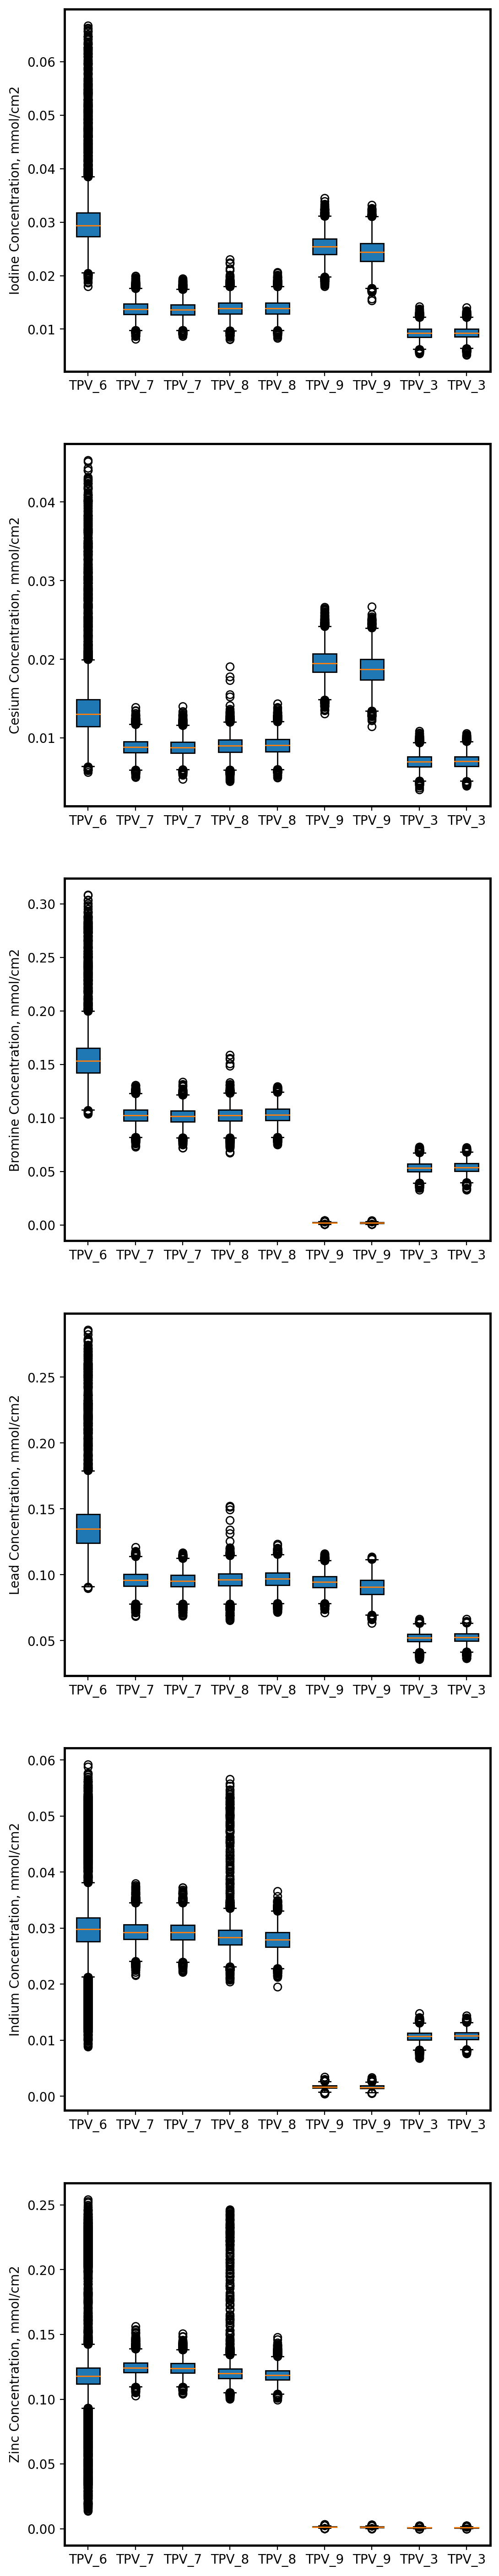

In [55]:
sample_list = ['literallyanything' for i in range(dfp.shape[0])]

for n in range(dfp.shape[0]):
    sample_list[n] = dfp['sample'][n]

embiggen = 6
horiz = 1
vert = 6 # 7 channels + 1 ratio
fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen, vert*embiggen))

all_data_1 = [dfp['IL_flat'][n] for n in range(dfp.shape[0])]
ax[0].boxplot(all_data_1, labels = sample_list, patch_artist=True)
ax[0].set_ylabel('Iodine Concentration, mmol/cm2')
# ax[0].set_xlabel('Chlorine Loading, %')

all_data_2 = [dfp['CsL_flat'][n] for n in range(dfp.shape[0])]
ax[1].boxplot(all_data_2, labels = sample_list, patch_artist=True)
ax[1].set_ylabel('Cesium Concentration, mmol/cm2')
# ax[1].set_xlabel('Chlorine Loading, %')


all_data_3 = [dfp['BrK_flat'][n] for n in range(dfp.shape[0])]
ax[2].boxplot(all_data_3, labels = sample_list, patch_artist=True)
ax[2].set_ylabel('Bromine Concentration, mmol/cm2')
# ax[2].set_xlabel('Chlorine Loading, %')

all_data_4 = [dfp['PbL_flat'][n] for n in range(dfp.shape[0])]
ax[3].boxplot(all_data_4, labels = sample_list, patch_artist=True)
ax[3].set_ylabel('Lead Concentration, mmol/cm2')
# ax[3].set_xlabel('Chlorine Loading, %')



all_data_5 = [dfp['InL_flat'][n] for n in range(dfp.shape[0])]
ax[4].boxplot(all_data_5, labels = sample_list, patch_artist=True)
ax[4].set_ylabel('Indium Concentration, mmol/cm2')
# ax[4].set_xlabel('Chlorine Loading, %')

all_data_5 = [dfp['ZnK_flat'][n] for n in range(dfp.shape[0])]
ax[5].boxplot(all_data_5, labels = sample_list, patch_artist=True)
ax[5].set_ylabel('Zinc Concentration, mmol/cm2')
# ax[5].set_xlabel('Chlorine Loading, %')


plt.show()

## Correlation Plots, takes a while to run!

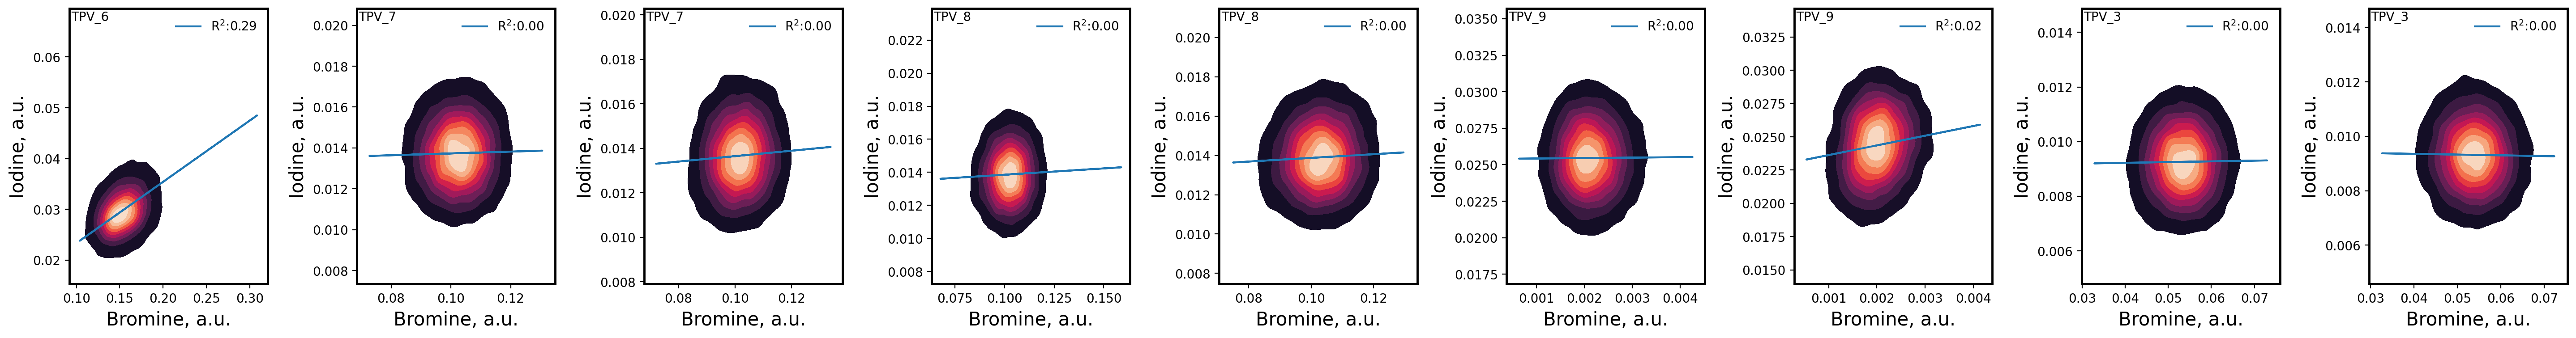

In [59]:
embiggen = 4
horiz = dfp.shape[0]
vert = 1 # 7 channels + 1 ratio

fig, ax = plt.subplots(vert, horiz, figsize = (horiz*embiggen, vert*embiggen))
from scipy import stats

for n in range(0, dfp.shape[0]):

    x = dfp['BrK_flat'][n]#*mask_array_low[n]
    y = dfp['IL_flat'][n]#*mask_array_low[n]

    sns.kdeplot(x = x, y = y,  cmap="rocket", shade=True, bw_method='scott', ax=ax[n])
    # sns.scatterplot(x = x, y = y ,ax=ax, color='w', size=1, alpha=.1) #if you want the points, looks dumb if you have a lot of points

    res = stats.linregress(x, y)
    rsq = res.rvalue**2
    ax[n].plot(x, res.intercept + res.slope*x, 'r', label=f'R$^2$:{rsq:.2f}', color='tab:blue')
    ax[n].legend(frameon=False)


    ax[n].set_xlabel('Bromine, a.u.', size=15)
    ax[n].set_ylabel('Iodine, a.u.', size=15)
    
    ax[n].text(0.01, .99, s = (dfp['sample'][n]), horizontalalignment='left', verticalalignment='top', transform=ax[n].transAxes)

fig.subplots_adjust(wspace=.45, hspace=-.2)

plt.show()

## Extra: Pin Hole Masking, Do this before plotting if necessary 

/Users/deniz/opt/anaconda3/envs/ds/lib/python3.7/site-packages/ipykernel_launcher.py:31: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))


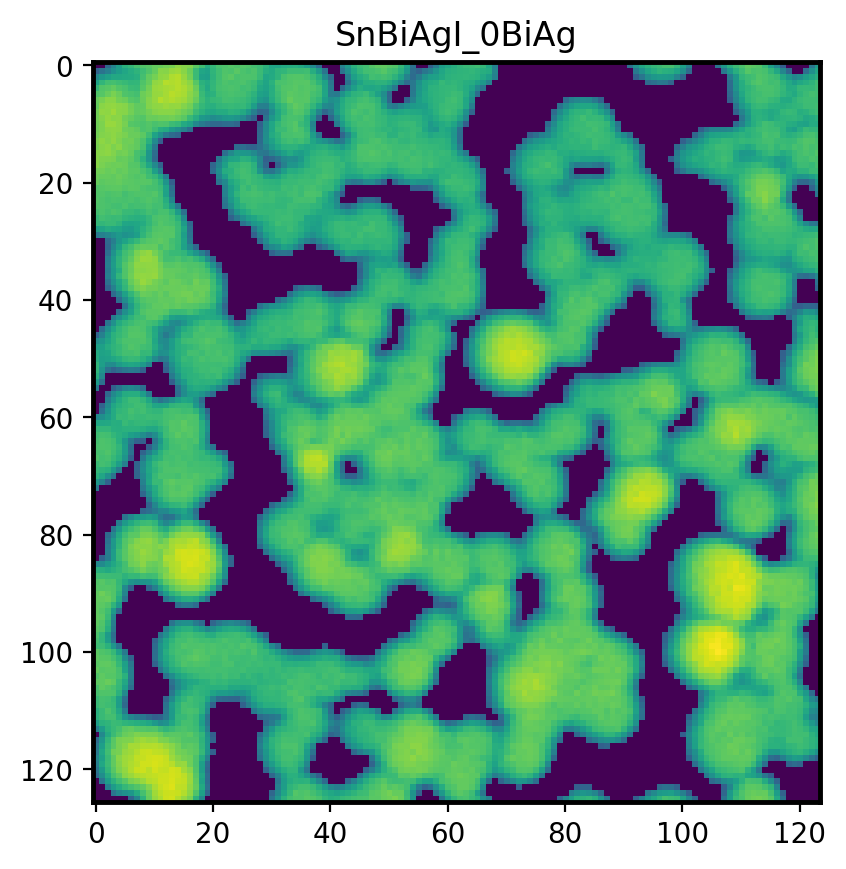

In [168]:
# example from a differnt sample with Pinholes, the TPV samples didn't seem to have any
dfp = df_filter3

mask_array_low = []
mask_array_high = []

# generating an empty list
for n in range(dfp.shape[0]):
    mask_array_low.append(dfp['I_L_mol'][0])
    mask_array_high.append(dfp['I_L_mol'][0])
    
    
# case study for pinhole check
q = 1

#value to mask at or below
mask_value_low = 0.17

#to look at a specific region of scan
frame = np.index_exp[25:, 25:]

# mask_value_high = 0

for n in range(dfp.shape[0]):
    mask_array_low[n] = dfp['I_L_mol'][n] > mask_value_low
#     print(n)

embiggen = 4
horiz = 1
vert = 0 # 7 channels + 1 ratio
fig, ax = plt.subplots()

img_masked_low = dfp['I_L_mol'][q].copy()

cm1 = mpl.cm.viridis
cm2 = mpl.cm.PRGn
cmap_choice = cm1

cm1.set_bad(color='black')

ax.imshow((img_masked_low * mask_array_low[q])[frame], cmap  = cmap_choice) 

# so now if you want to apply the mask just do: image * mask_array_low[n]


ax.set_title(dfp['sample'][q])

plt.show()